##### Это финальное задание по курсу «Обучение на размеченных данных».

В нем вы сравните логистическую регрессию и случайный лес на разных наборах признаков. В качестве данных будет использован Adult Data Set из репозитория UCI. В нем нужно предсказать, получает ли человек больше 50 000$ в год, или нет, по ряду признаков, таких как пол, образование, раса и др. Подробное описание можно найти по ссылке: https://archive.ics.uci.edu/ml/datasets/Adult.

In [37]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt

### Загрузка данных

В ходе задания будем использовать __train_data.csv__ для обучения моделей, на нем же и будем производить кросс-валидацию. В качестве отложенной выборки будем использовать __test_data.csv__

In [38]:
column_names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
                "hours-per-week", "native-country", "class"]

In [39]:
train = pd.read_csv("train_data.csv", sep=", ", header=None, engine="python", names=column_names)

In [40]:
test = pd.read_csv("test_data.csv", sep=", ", header=None, engine="python", names=column_names)

### 1. Пропущенные значения 

В обучающей выборке порядка 7% строк имеют пропущенные значения (вместо значения поля указан вопросительный знак __'?'__). В каких признаках в обучающей и тестовой выборке имеются пропущенные значения? Так как они все пропущены в категориальных признаках, то можно пока их ни на что не заменять, а просто считать еще одной категорией.

In [41]:
print([c for c in column_names if '?' in train[c].values])
print([c for c in column_names if '?' in test[c].values])

['workclass', 'occupation', 'native-country']
['workclass', 'occupation', 'native-country']


### 2. Обучение на вещественных признаках

В этом разделе обучите модели только на вещественных признаках ("continuous" в описании данных). Обучите логистическую регрессию (linear_model.LogisticRegression) и случайный лес (ensemble.RandomForestClassifier) из sklearn. В первом случае подберите оптимальные параметры $penalty$ и $C$ на отрезке $[10^{-6}, 10^{6}]$ (по степеням $10$ с шагом $1$, начиная с $-6$), а во втором при фиксированном числе деревьев в 50 подберите $max\_depth$ и $min\_samples\_split$ из отрезка $[2, 14]$ с шагом в 2 и множества $\{1, 2, 4, 8\}$ соответственно. За целевую метрику качества возьмите AUC-ROC. В качестве схемы валидации используйте стратифицированную кросс-валидацию по 5-ти фолдам. Какие параметры оказались оптимальными?

Учтите, что целевая переменная в датасете является строкой. Поэтому для начала ее нужно перевести в бинарную величину. Также не забудьте отмасштабировать данные с помощью StandartScaler'а из модуля preprocessing.

In [42]:
cont_column_names = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
cat_column_names = set(column_names) - set(cont_column_names) - {'class'}
scaler = StandardScaler()

def process(data):
    x_cont = scaler.fit_transform(data[cont_column_names])
    x_cat = data[cat_column_names]
    y = data['class']
    y[y == '<=50K'] = 0
    y[y == '>50K'] = 1
    y = pd.to_numeric(y)
    return (x_cont, x_cat, y)
    

x_train_cont, x_train_cat, y_train = process(train)
x_test_cont, x_test_cat, y_test = process(test)

In [43]:
lr = LogisticRegression()
params = {
    'C' : [10 ** p for p in range(-6, 7)],
    'penalty' : ['l1', 'l2']
}
cv = StratifiedKFold(n_splits=5)
grid_lr = GridSearchCV(lr, params, scoring = 'roc_auc', cv = cv)

In [44]:
%%time
grid_lr.fit(x_train_cont, y_train)
print(grid_lr.best_score_)
print(grid_lr.best_params_)

0.8316014389179222
{'C': 0.1, 'penalty': 'l2'}
CPU times: user 13.5 s, sys: 503 ms, total: 14 s
Wall time: 7.8 s


In [73]:
rfc = RandomForestClassifier(n_estimators=50)
params = {
    'max_depth' : np.arange(2, 16, 2),
    'min_samples_split' : [2, 4, 8]
}
grid_rfc = GridSearchCV(rfc, params, scoring = 'roc_auc', cv = cv)

In [74]:
%%time
grid_rfc.fit(x_train_cont, y_train)
print(grid_rfc.best_score_)
print(grid_rfc.best_params_)

0.8630528812881437
{'max_depth': 12, 'min_samples_split': 8}
CPU times: user 1min 45s, sys: 1.36 s, total: 1min 46s
Wall time: 1min 50s


Посчитайте accuracy, precision, recall, f1-score и AUC-ROC на отложенной выборке для оптимальных алгоритмов. Какие они получились? Какой алгоритм лучше?

In [58]:
def calc_metrics(estimator, x, y):
    y_pred = estimator.predict(x)
    y_pred_proba = estimator.predict_proba(x)[:, 1]
    res = {}
    res['accuracy'] = metrics.accuracy_score(y, y_pred)
    res['precision'] = metrics.precision_score(y, y_pred)
    res['recall'] = metrics.recall_score(y, y_pred)
    res['f1'] = metrics.f1_score(y, y_pred)
    res['roc auc'] = metrics.roc_auc_score(y, y_pred_proba)
    return res

In [48]:
df_lr_results = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'f1', 'roc auc'],
                 columns=pd.Index(['continuous', 'label encoding', 'binary encoding'], 
                 name='Logistic regression'))
df_rf_results = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'f1', 'roc auc'],
                 columns=pd.Index(['continuous', 'label encoding', 'binary encoding'], 
                 name='Random forest classifier'))

In [49]:
def update_res_table(df, res, col):
    for key in res.keys():
        df[col][key] = res[key]

In [59]:
res = calc_metrics(grid_lr.best_estimator_, x_test_cont, y_test)
print(res)
update_res_table(df_lr_results, res, 'continuous')

{'accuracy': 0.8127879122903998, 'precision': 0.686623012160898, 'recall': 0.38169526781071245, 'f1': 0.4906417112299466, 'roc auc': 0.825422315646144}


In [60]:
res = calc_metrics(grid_rfc.best_estimator_, x_test_cont, y_test)
print(res)
update_res_table(df_rf_results, res, 'continuous')

{'accuracy': 0.8324427246483631, 'precision': 0.7578413284132841, 'recall': 0.42719708788351535, 'f1': 0.5463917525773196, 'roc auc': 0.8533761832982367}


Вывод: случайный лес дает лучшее качество, чем логистическая регрессия

### 3. Категориальные признаки как есть

Теперь к вещественным добавьте категориальные признаки, заменив их на числа с помощью LabelEncoder из модуля preprocessing. Переподберите параметры для логистической регрессии и случайного леса аналогично прошлому пункту. Как изменилось качество моделей на тестовой выборке? Как вы можете это объяснить?

In [79]:
le = LabelEncoder()
x_train_cat_labeled = x_train_cat.apply(le.fit_transform)
x_test_cat_labeled = x_test_cat.apply(le.fit_transform)
x_train = np.hstack((x_train_cont, x_train_cat_labeled))
x_test = np.hstack((x_test_cont, x_test_cat_labeled))

In [62]:
%%time
grid_lr.fit(x_train, y_train)
print(grid_lr.best_score_)
print(grid_lr.best_params_)

0.8538901413953228
{'C': 1000000, 'penalty': 'l1'}
CPU times: user 58.3 s, sys: 1.46 s, total: 59.8 s
Wall time: 41.2 s


In [63]:
res = calc_metrics(grid_lr.best_estimator_, x_test, y_test)
print(res)
update_res_table(df_lr_results, res, 'label encoding')

{'accuracy': 0.824887906148271, 'precision': 0.7041444398851047, 'recall': 0.44617784711388453, 'f1': 0.546235874582206, 'roc auc': 0.8508763615522505}


In [64]:
%%time
grid_rfc.fit(x_train, y_train)
print(grid_rfc.best_score_)
print(grid_rfc.best_params_)

0.914312324546408
{'max_depth': 12, 'min_samples_split': 4}
CPU times: user 22.7 s, sys: 468 ms, total: 23.1 s
Wall time: 23.5 s


In [65]:
res = calc_metrics(grid_rfc.best_estimator_, x_test, y_test)
print(res)
update_res_table(df_rf_results, res, 'label encoding')

{'accuracy': 0.8584853510226644, 'precision': 0.774768353528154, 'recall': 0.5652626105044202, 'f1': 0.6536380036079374, 'roc auc': 0.9098826116293546}


Вывод: качество моделей на тестовой выборке повысилось. Добавление категориальных признаков повысило степень обученности моделей.

### 4. Бинарное кодирование категориальных признаков

А теперь замените категориальные признаки из прошлого пункта на бинарно закодированные. Опять переподберите параметры для моделей и проверьте качество на тестовой выборке. Как изменилось качество относительно предыдущего пункта? Как вы можете это объяснить?

In [66]:
encoder = DictVectorizer(sparse = False)
x_train_cat_oh = encoder.fit_transform(x_train_cat.T.to_dict().values())
x_test_cat_oh = encoder.transform(x_test_cat.T.to_dict().values())
x_train = np.hstack((x_train_cont, x_train_cat_oh))
x_test = np.hstack((x_test_cont, x_test_cat_oh))

In [68]:
%%time
grid_lr.fit(x_train, y_train)
print(grid_lr.best_score_)
print(grid_lr.best_params_)

0.9068720085126994
{'C': 1, 'penalty': 'l2'}
CPU times: user 2min 41s, sys: 3.36 s, total: 2min 45s
Wall time: 2min 39s


In [69]:
res = calc_metrics(grid_lr.best_estimator_, x_test, y_test)
print(res)
update_res_table(df_lr_results, res, 'binary encoding')

{'accuracy': 0.8530188563356059, 'precision': 0.7299778410889523, 'recall': 0.5995839833593344, 'f1': 0.6583868665239115, 'roc auc': 0.9054422257308468}


In [70]:
%%time
grid_rfc.fit(x_train, y_train)
print(grid_rfc.best_score_)
print(grid_rfc.best_params_)

0.9105070105868811
{'max_depth': 14, 'min_samples_split': 4}
CPU times: user 35.7 s, sys: 1.07 s, total: 36.7 s
Wall time: 37.6 s


In [71]:
res = calc_metrics(grid_rfc.best_estimator_, x_test, y_test)
print(res)
update_res_table(df_rf_results, res, 'binary encoding')

{'accuracy': 0.8581168232909526, 'precision': 0.7694736842105263, 'recall': 0.5702028081123245, 'f1': 0.6550179211469535, 'roc auc': 0.9081965900268498}


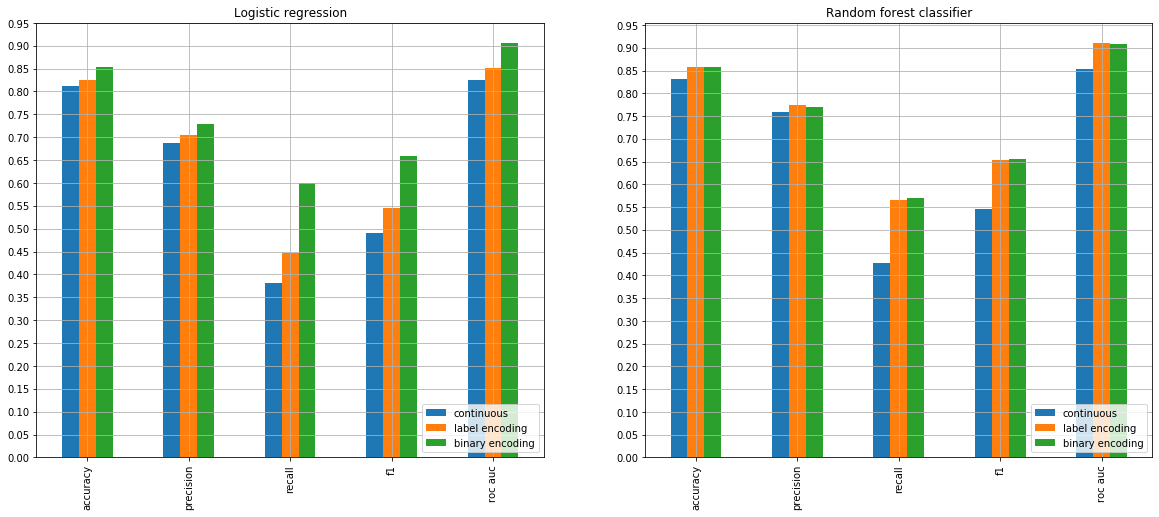

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=2)
df_lr_results.plot(ax=axes[0], kind='bar', figsize=(20, 8), title='Logistic regression')
df_rf_results.plot(ax=axes[1], kind='bar', figsize=(20, 8), title='Random forest classifier')
for ax in axes:
    ax.legend(loc='lower right')
    ax.grid()
    ax.set_yticks(np.arange(0,1,0.05))
plt.show()

Вывод: по сравнению с предыдущим пунктом качество повысилось значительнее для логистической регрессии. Возможно, это связано с тем, что логистическая регрессия обрабатывает признаки, закодированные с помощью LabelEncoder как упорядоченные, а бинарно закодированные - как неупорядоченные. Отсюда и более заметный (в сравнении со случайным лесом) прирост по качеству при бинарном кодировании. Случайный лес же вне зависимости от кодирования (label или binary) обрабатывает категориальные признаки как неупорядоченные. Поэтому и ощутимой разницы в качестве при смене способа кодирования для него нет.